<a href="https://colab.research.google.com/github/inseungkang/learningalgos/blob/main/readc3d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My Drive/Inseung_LearningAlgos/
!pip3 install c3d

Mounted at /content/drive
/content/drive/My Drive/Inseung_LearningAlgos


In [ ]:
from google.colab import output
#I don't know why nbextensions don't work with python3.6 
with output.temporary():
  !pip install --upgrade git+https://github.com/Kreijstal/colab_inspector.git 
  !python2.7 -m pip install --upgrade git+https://github.com/blois/colab_inspector.git #yes, really.
  !jupyter nbextension install --py inspector

import inspector

# open a scratch cell (Ctrl+Alt+N)
# run there
# inspector.watch_globals()

In [2]:
import numpy as np
import pandas as pd
import os
import c3d
import matplotlib.pyplot as plt

file_name = os.listdir()

In [4]:
markerData = np.empty((36, 5, 1))
forceData = np.empty((18, 10, 1))

with open(file_name[0], 'rb') as handle:
  reader = c3d.Reader(handle)
  markerLabel = reader.point_labels
  forceLabel = reader.analog_labels
  
  markerName = ['RASI','LASI','RPSI','LPSI','RANL','LANL']
  forceName = ['RASI','LASI','RPSI','LPSI','RANL','LANL']

  idxList = []
  for _, name in enumerate(markerName):
    for idx, label in enumerate(markerLabel):
      if name == label.strip():
        idxList.append(idx)
      
  
  print(reader.analog_labels)
  
# !c3d2npz AB1_Session1_Right14_Left14.c3d
# !c3d-metadata AB1_Session1_Right10_Left10.c3d

# for _, (idx, marker, force) in enumerate(reader.read_frames()):
#   print(reader)
#   markerData = np.concatenate((markerData, np.expand_dims(marker, axis=2)), axis=2)
#   forceData = np.concatenate((forceData, np.expand_dims(force, axis=2)), axis=2)
#   if idx == 200:
#     break

['Force.Fx1       ' 'Force.Fy1       ' 'Force.Fz1       '
 'Moment.Mx1      ' 'Moment.My1      ' 'Moment.Mz1      '
 'Force.Fx2       ' 'Force.Fy2       ' 'Force.Fz2       '
 'Moment.Mx2      ' 'Moment.My2      ' 'Moment.Mz2      '
 'Force.Fx3       ' 'Force.Fy3       ' 'Force.Fz3       '
 'Moment.Mx3      ' 'Moment.My3      ' 'Moment.Mz3      ']


In [28]:
indexList = [34, 2, 0, 1, 20, 26]
b = np.load('AB1_Session1_Right14_Left14.npz')
markerData = b['points']
forceData = b['analog']

# Extract all raw data into relevant marker and force data
# Truncate data with a sync force plate (for session 1, extracting 6 min)
force_sync = np.mean(forceData[:,14,:], axis=1)

trial_time = 6
start_idx = np.argwhere(abs(force_sync) > np.max(abs(force_sync))/2)[0,0]
end_idx = start_idx + trial_time*6000

foot_r = markerData[start_idx:end_idx, indexList[4], 0:3]
foot_l = markerData[start_idx:end_idx, indexList[5], 0:3]
com = np.mean(markerData[start_idx:end_idx, indexList[0:4], 0:3], axis=1)
force_r = np.mean(forceData[start_idx:end_idx, 0:3, :], axis=2)
force_l = np.mean(forceData[start_idx:end_idx, 6:9, :], axis=2)

In [21]:
# Using stance index, segment data out to concat every gait cycle
def data_2_gc_resample(input_data, stance_idx):
  gait_cycle_data = np.empty((1000, len(stance_idx)-1, 1))
  
  # Each axis data resampled to 1000 datapoints
  for axis in np.arange(0, 3):
    axis_vec = np.empty((1000, 1))

    for idx in np.arange(len(stance_idx)-1):
      input_vec = input_data[stance_idx[idx,0]:stance_idx[idx+1,0], axis]
      out_vec = np.interp(
              np.linspace(0.0, 1.0, 1000, endpoint=False),
              np.linspace(0.0, 1.0, len(input_vec), endpoint=False),
              input_vec,)
      axis_vec = np.concatenate((axis_vec, np.expand_dims(out_vec, axis=1)), axis=1)

    axis_vec = axis_vec[:,1:]
    gait_cycle_data = np.concatenate((gait_cycle_data, np.expand_dims(axis_vec, axis=2)), axis=2)
  
  return gait_cycle_data[:, :, 1:]

# Obtain stance phase using force vector and compute heel contact index for each leg
def compute_stance_idx(force_data):

  stance = np.where(force_data < -100, 1, np.zeros(len(force_data)))

  stance_start = np.where(np.diff(stance) == 1)[0]
  stance_end = np.where(np.diff(stance) == -1)[0]

  # Check the stance start and end index to match total stance index array size
  if stance_start[0] > stance_end[0]:
    stance_end = stance_end[1:]

  if len(stance_start) < len(stance_end):
    stance_end = stance_end[:len(stance_start)]
  else:
    stance_start = stance_start[:len(stance_end)]

  # stack two stance index array together
  stance_idx = np.concatenate((stance_start.reshape(-1,1), stance_end.reshape(-1,1)), axis=1)

  return stance_idx

def compStance(force_right, force_left):
  stance_right = np.where(force_right < -100, 1, np.zeros(len(force_right)))
  stance_start_right = np.where(np.diff(stance_right) == 1)[0]

  stance_left = np.where(force_left < -100, 1, np.zeros(len(force_left)))
  stance_start_left = np.where(np.diff(stance_left) == 1)[0]

  # Check the stance start and end index to match total stance index array size

  if stance_start_right[0] > stance_start_left[0]:
    stance_start_left = stance_start_left[1:]

  if len(stance_start_right) < len(stance_start_left):
    stance_start_left = stance_start_left[:len(stance_start_right)]
  else:
    stance_start_right = stance_start_right[:len(stance_start_left)]

  # stack two stance index array together
  stance_idx = np.concatenate((stance_start_right.reshape(-1,1), stance_start_left.reshape(-1,1)), axis=1)



  return stance_idx  

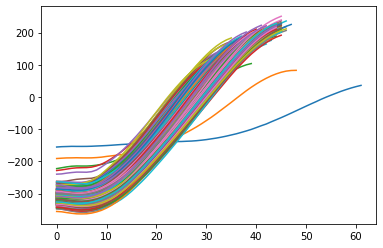

In [74]:
stance_idx = compStance(force_r[:,2], force_l[:,2])
# for ii in np.arange(len(stance_idx)):

for ii in np.arange(300):
  com_stance = com[stance_idx[ii,0]:stance_idx[ii,1]]
  foot_r_stance = foot_r[stance_idx[ii,0]:stance_idx[ii,1]]


  normalized_com = com_stance[:,1] - foot_r_stance[:,1]
  plt.plot(normalized_com)

  # print(foot_stance_Y_right.shape)

# stance_idx = np.empty((1,2))
# print(stance_idx_r[100][1])
# for i in np.arange(len(stance_idx_r)):
#   stance_idx = np.concatenate(stance_idx, [stance_idx_r[i][0], 0].reshape(-1,1))


# plt.plot(com[:,2])
# plt.plot(stance_idx[:,0],np.ones(len(stance_idx))*np.mean(com[:,2]),'ro')
# plt.plot(stance_idx[:,1],np.ones(len(stance_idx))*np.mean(com[:,2]),'bo')
# plt.xlim(10000,10500)
# plt.show()

In [15]:
stance_idx_r = compute_stance_idx(force_r[:,2])
stance_idx_l = compute_stance_idx(force_l[:,2])

foot_r = data_2_gc_resample(foot_r, stance_idx_r)
foot_l = data_2_gc_resample(foot_l, stance_idx_l)
com = data_2_gc_resample(com, stance_idx_r)
# x = np.arange(len(force_r[:,2]))
# heel = np.ones(len(stance_idx_r))*-100
# plt.plot(x, force_r[:,2])
# plt.plot(stance_idx_r[:,0], heel,'ro')
# plt.plot(stance_idx_r[:,1], heel,'bo')
# plt.xlim(15000, 15500)





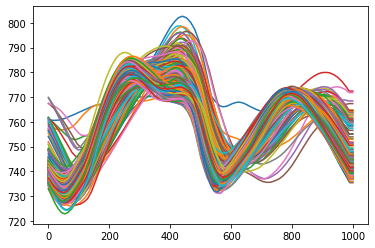

In [19]:
plt.plot(com[:,:,2])
# # plt.ylim(-2, 2)
plt.show()

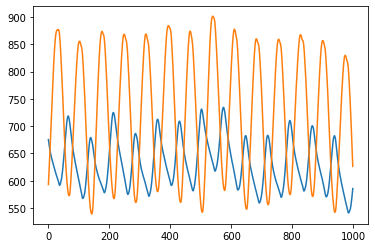

In [ ]:
# COM trajectory
# test out the example of Pelvis Y

pelvis_Y = com[1000:2000,1]
foot_Y = foot_r[1000:2000,1]

plt.plot(pelvis_Y)
plt.plot(foot_Y)

# plt.plot(com[:,2])
# plt.xlim(5000, 5500)

In [ ]:
# COM trajectory
# test out the example of Pelvis Y

pelvis_Y = com[:,1]
foot_r_Y = foot_r[:,1]

# Find zero crossing
normalized_r_Y = pelvis_Y-foot_r_Y
mid_stance_idx = []
stance_start_idx = []

for i in np.arange(len(normalized_r_Y)):
    if normalized_r_Y[i] < 0 and normalized_r_Y[i+1] > 0:
      mid_stance_idx.append(i)

      if len(mid_stance_idx) > 1:
        test_vec = normalized_r_Y[mid_stance_idx[-2]:mid_stance_idx[-1]]
        min_loc = np.where(test_vec == test_vec.min())[0][0]
        min_loc = min_loc + mid_stance_idx[-2]
        stance_start_idx.append(min_loc)


print(stance_start_idx)
print(mid_stance_idx)


[179, 271, 357, 435, 508, 579, 656, 730, 810, 886, 960, 1035, 1109, 1181, 1256, 1322, 1401, 1467, 1545, 1618, 1690, 1762, 1836, 1907, 1982, 2054, 2128, 2198, 2275, 2348, 2423, 2496, 2573, 2648, 2722, 2796, 2870, 2946, 3021, 3096, 3175, 3252, 3328, 3406, 3483, 3562, 3638, 3716, 3794, 3873, 3950, 4031, 4110, 4189, 4268, 4346, 4422, 4500, 4579, 4658, 4737, 4816, 4894, 4971, 5049, 5127, 5204, 5283, 5358, 5435, 5511, 5588, 5665, 5743, 5820, 5899, 5977, 6056, 6136, 6217, 6297, 6376, 6455, 6534, 6609, 6687, 6766, 6842, 6921, 7000, 7080, 7159, 7240, 7318, 7397, 7474, 7551, 7631, 7711, 7791, 7870, 7951, 8032, 8112, 8193, 8276, 8357, 8440, 8525, 8607, 8689, 8772, 8855, 8937, 9019, 9101, 9185, 9266, 9349, 9431, 9513, 9594, 9677, 9761, 9844, 9926, 10010, 10094, 10177, 10260, 10343, 10427, 10510, 10595, 10680, 10766, 10849, 10932, 11017, 11103, 11187, 11271, 11355, 11439, 11524, 11606, 11690, 11773, 11857, 11941, 12027, 12112, 12197, 12281, 12367, 12451, 12535, 12620, 12704, 12789, 12876, 12961, 13

In [ ]:



print(stance_phase_idx.shape)
print(len(mid_stance_idx))
# for ii in np.arange(len(mid_stance_idx))-1:
#       ABC = normalized_r_Y[mid_stance_idx[ii]:mid_stance_idx[ii+1]]
      # stance_start_idx.append(np.where(ABC == ABC.min()))

# x1 = np.arange(len(normalized_r_Y))
# mid = np.zeros(len(mid_stance_idx))
# heel = np.zeros(len(stance_start_idx))

# print(np.where(ABC == ABC.min()))
# plt.plot(stance_start_idx, heel,'o')
# plt.plot(mid_stance_idx, mid,'o')
# plt.plot(x1,normalized_r_Y)
# plt.xlim(5000, 5500)

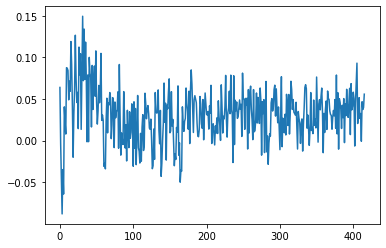

In [ ]:
# Using heel contact index, compute SLA for each leg
step_length_r = foot_r[idx_heel_r,1] - foot_l[idx_heel_r,1]
step_length_l = foot_l[idx_heel_l,1] - foot_r[idx_heel_l,1]
SLA = (step_length_r - step_length_l)/(step_length_r + step_length_l)

# plt.plot(SLA)
# plt.show()


normalized_r_Y = pelvis_Y-foot_r_Y

for i in np.arange(idx_heel_r)-1:
  normalized_r_y(idx_heel_r[i]:idx_heel_r[i+1])